In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import torch
import torch.nn as nn

Running Random


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Running UCB


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Running LinearQAgent


100%|██████████| 5/5 [01:08<00:00, 13.78s/it]


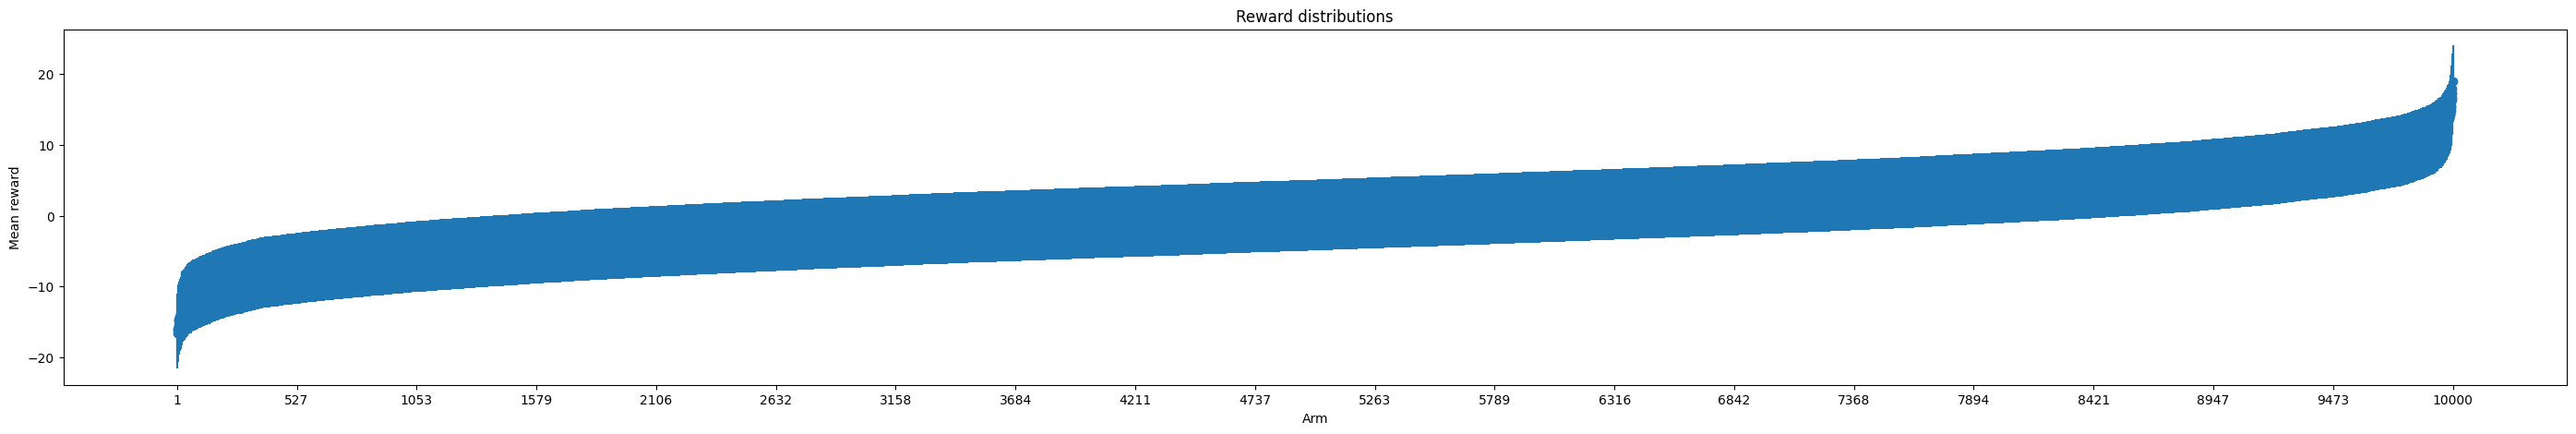

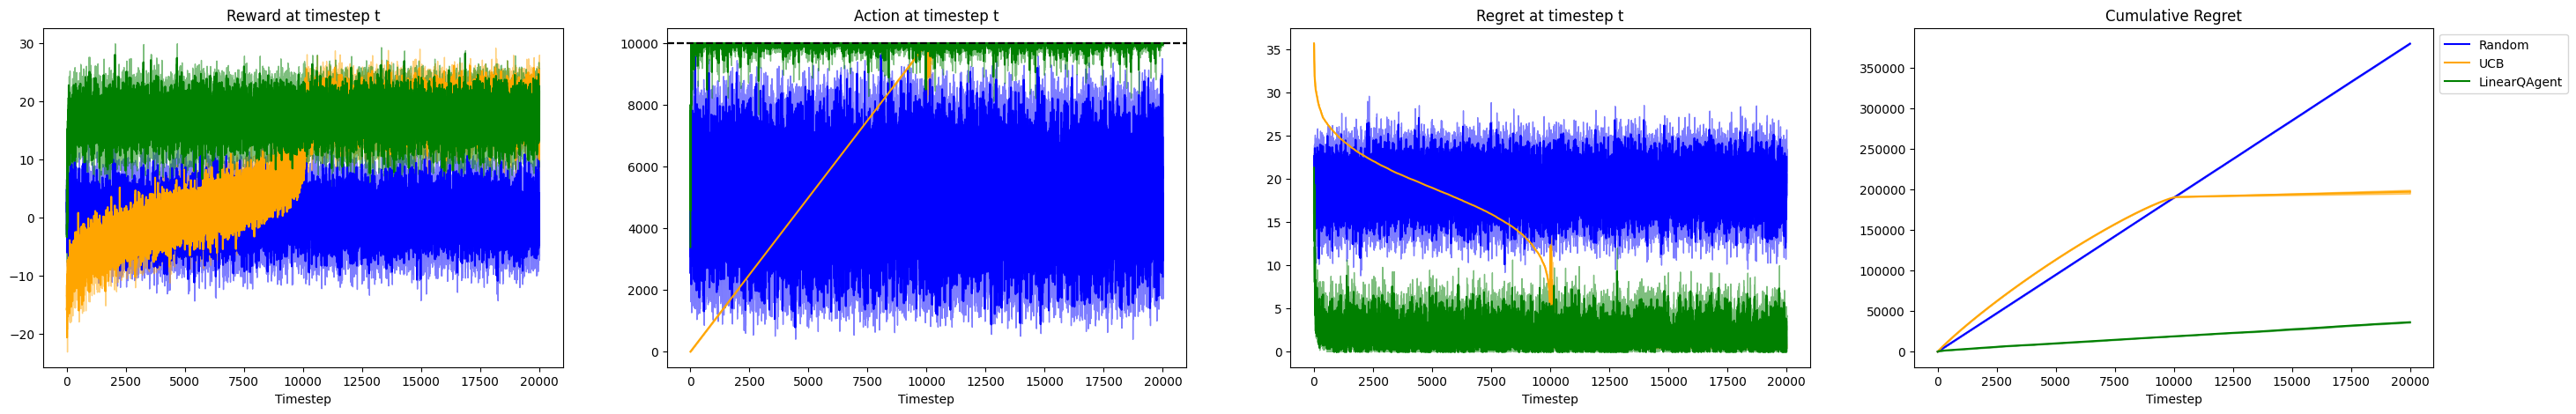

In [45]:
class LinearMultiArmBandit:
    """
    This class is what our agents will interact with.
    In __init__:
    - It instantiates the arms' reward distributions
    - It sets the step counter to 0
    - It initialises the reward, action, regret lists
    In pull_arm:
    - It increments the step counter
    - It samples the reward from the arm's reward distribution
    - It calculates the regret
    - It returns the reward
    """
    def __init__(self, k, d=8, reward_std=1., improve_best_action_n=10, sort_arms=True):
        self.k = k
        self.d = d
        self.reward_std = reward_std
        self.step = 0
        self.reward_list = []
        self.action_list = []
        self.regret_list = []
        self.arms = [np.random.normal(0, 1, d) for _ in range(k)]
        self.true_theta = np.random.normal(0, 1, d)
        if sort_arms:
            self.arms = list(sorted(self.arms, key=lambda x: np.dot(self.true_theta, x)))
        self.best_arm = np.argmax([self.get_mean_reward(arm) for arm in range(self.k)])
        if improve_best_action_n is not None:
            for _ in range(improve_best_action_n):
                self.improve_best_action()

    def pull_arm(self, arm):
        self.step += 1
        reward = self.get_reward(arm)
        regret = self.get_regret(arm)
        self.reward_list.append(reward)
        self.action_list.append(arm)
        self.regret_list.append(regret)
        return reward

    def improve_best_action(self):
        # takes a few gradient steps to modify the best_arm's feature vector to make it even more dominant
        # reward = theta @ x
        # gradient_x = theta
        # update on x: x = x + lr * theta
        self.arms[self.best_arm] += 0.1 * self.true_theta

    def get_mean_reward(self, arm):
        return np.dot(self.true_theta, self.arms[arm])

    def get_reward(self, arm):
        return np.random.normal(np.dot(self.true_theta, self.arms[arm]), self.reward_std)

    def get_regret(self, arm):
        regret = np.dot(self.true_theta, self.arms[self.best_arm]) - np.dot(self.true_theta, self.arms[arm])
        assert regret >= 0
        return regret

    def reset(self):
        self.step = 0
        self.reward_list = []
        self.action_list = []
        self.regret_list = []


# -----------------


class BanditAgent:
    def select_arm(self):
        raise NotImplementedError
    def update(self, arm, reward):
        raise NotImplementedError

class RandomAgent(BanditAgent):
    # This agent chooses a random arm at each step
    def __init__(self, k):
        self.k = k
    def select_arm(self):
        return np.random.randint(0, self.k)
    def update(self, arm, reward):
        pass
    
class QAgent(BanditAgent):
    def __init__(self, k):
        self.k = k
        self.q_values = np.zeros(k)
        self.n_selections = np.zeros(k)
    def select_arm(self):
        raise NotImplementedError
    def update(self, arm, reward):
        raise NotImplementedError

class UCBAgent(QAgent):
    # This agent selects the arm with the highest Upper Confidence Bound (UCB)
    # The UCB is the sum of the q-value and a term that increases with the total 
    # number of steps and decreases with the number of times the arm has been selected
    def __init__(self, k, c=1.):
        super().__init__(k)
        self.c = c
    def select_arm(self):
        if 0 in self.n_selections:
            return np.argmin(self.n_selections)
        ucb_values = self.q_values + self.c * np.sqrt(np.log(np.sum(self.n_selections)) / (self.n_selections))
        return np.argmax(ucb_values)
    def update(self, arm, reward):
        self.n_selections[arm] += 1
        self.q_values[arm] += (reward - self.q_values[arm]) / self.n_selections[arm]

class LinearUCBAgent(QAgent):
    def __init__(self, k, d=10, c=1.):
        super().__init__(k)
        self.d = d
        self.c = c
        self.arms = np.random.normal(0, 1, (k, d))
        self.theta = np.zeros(d)
        self.A = np.array([np.eye(d) for _ in range(k)])
        self.b = np.zeros((k, d))
    def select_arm(self):
        ucb_values = np.array([np.dot(self.theta, self.arms[arm]) + self.c * np.sqrt(np.dot(self.arms[arm], np.linalg.solve(self.A[arm], self.arms[arm]))) for arm in range(self.k)])
        return np.argmax(ucb_values)
    def update(self, arm, reward):
        self.A[arm] += np.outer(self.arms[arm], self.arms[arm])
        self.b[arm] += self.arms[arm] * reward
        self.theta = np.linalg.solve(self.A[arm], self.b[arm])

class LinearQAgent(QAgent):
    def __init__(self, k, arms, d=10, lr=0.1, temperature=0.1):
        super().__init__(k)
        self.d = d
        self.lr = lr
        self.arms = np.array(arms)
        self.theta = np.zeros(d)
        self.temperature = temperature
    def softmax(self, x, temp):
        x = x - np.max(x)
        return np.exp(x / temp) / np.sum(np.exp(x / temp))
    def select_arm(self):
        preferences = np.dot(self.arms, self.theta)
        return np.random.choice(np.arange(self.k), p=self.softmax(preferences, self.temperature))
    def update(self, arm, reward):
        self.theta += self.lr * (reward - np.dot(self.theta, self.arms[arm])) * self.arms[arm]
        

# -----------------

def show_results(logs, bandit, n_episodes, ep_len, agents):
    # plot reward distributions
    fig, ax = plt.subplots(1, 1, figsize=(35, 5))
    ax.set_title('Reward distributions')
    ax.set_xticks(np.arange(1, bandit.k + 1))
    ax.set_xticklabels(np.arange(1, bandit.k + 1))
    arm_means = [bandit.get_mean_reward(arm) for arm in range(bandit.k)]
    arm_stds = [bandit.reward_std for arm in range(bandit.k)]
    ax.errorbar(np.arange(1, bandit.k + 1), arm_means, yerr=arm_stds, fmt='o')
    ax.set_xlabel('Arm')
    ax.set_ylabel('Mean reward')
    # limit xticks to 20 ticks
    # make sure the first and final numbers are there
    xticks = np.linspace(1, bandit.k, num=20, dtype=int)
    xticks = np.unique(np.concatenate([xticks, [1, bandit.k]]))
    ax.set_xticks(xticks)

    # plot algorithm performance
    fig, ax = plt.subplots(1, 4, figsize=(35, 5))

    all_colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    agent_colors = {agent_name: color for agent_name, color in zip(agents.keys(), all_colors)}

    for agent_name, agent_logs in logs.items():
        for i, metric in enumerate(agent_logs.keys()):
            color = agent_colors[agent_name]
            mean = np.mean(agent_logs[metric], axis=0)
            ste = np.std(agent_logs[metric], axis=0) / np.sqrt(n_episodes)
            ax[i].plot(mean, label=agent_name, color=color)
            ax[i].set_xlabel('Timestep')
            ax[i].set_title(metric)
            if 'Action' in metric:
                ax[i].axhline(y=bandit.best_arm, color='black', linestyle='--')
            ax[i].fill_between(range(ep_len), mean - ste, mean + ste, alpha=0.5, color=color)
        
    ax[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))



# ------------

k = 10_000
d = 16
reward_std = 5.
n_episodes = 5
ep_len = 20_000
bandit = LinearMultiArmBandit(k, d=d, reward_std=reward_std, improve_best_action_n=0)

agents = {
    'Random': RandomAgent,
    'UCB': lambda k: UCBAgent(k, c=0.01),
    # 'LinearUCBAgent': lambda k: LinearUCBAgent(k, d=bandit.d, c=1.),
    'LinearQAgent': lambda k: LinearQAgent(k, arms=bandit.arms, d=bandit.d, lr=0.01, temperature=1.),
}

logs = {
    agent_name: {
        'Reward at timestep t': [],
        'Action at timestep t': [],
        'Regret at timestep t': [],
        'Cumulative Regret': [],
    } for agent_name in agents.keys()
}

for agent_name, Algo in agents.items():
    print(f'Running {agent_name}')
    for _ in tqdm(range(n_episodes)):
        agent = Algo(bandit.k)
        for _ in range(ep_len):
            arm = agent.select_arm()
            reward = bandit.pull_arm(arm)
            agent.update(arm, reward)
        logs[agent_name]['Reward at timestep t'].append(deepcopy(bandit.reward_list))
        logs[agent_name]['Action at timestep t'].append(deepcopy(bandit.action_list))
        logs[agent_name]['Regret at timestep t'].append(deepcopy(bandit.regret_list))
        logs[agent_name]['Cumulative Regret'].append(np.cumsum(bandit.regret_list))
        bandit.reset()

show_results(logs, bandit, n_episodes, ep_len, agents)